In [1]:
!pip install --upgrade tensorflow-gpu tensorflow-probability tensorflow-datasets

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python3.6/dist-packages (0.8.0)
Requirement already up-to-date: tensorflow-datasets in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow import math as tfm
import tensorflow_datasets as tfds

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

import numpy as np
import matplotlib.pyplot as plt

# Dense Variational Layer

In [0]:
class DenseVariational(tfkl.Layer):

    def __init__(
        self,
        units,
        activation=tf.identity,
        activity_regularizer=None,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_posterior_tensor_fn=lambda d: d.sample(),
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_divergence_fn=tfd.kl_divergence,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(),
        bias_posterior_tensor_fn=lambda d: d.sample(),
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_divergence_fn=tfd.kl_divergence,
        kl_weight = 1.,
        **kwargs):
        super(DenseVariational, self).__init__(activity_regularizer=activity_regularizer,**kwargs)
        self.units = units
        self.activation = tfk.activations.get(activation)
        self.input_spec = tfkl.InputSpec(min_ndim=2)
        self.kernel_posterior_fn = kernel_posterior_fn
        self.kernel_posterior_tensor_fn = kernel_posterior_tensor_fn
        self.kernel_prior_fn = kernel_prior_fn
        self.bias_posterior_fn = bias_posterior_fn
        self.bias_posterior_tensor_fn = bias_posterior_tensor_fn
        self.bias_prior_fn = bias_prior_fn
        self.kernel_divergence_fn = kernel_divergence_fn
        self.bias_divergence_fn = bias_divergence_fn
        self.kl_weight = kl_weight

    def build(self, input_shape):
        input_shape = tf.TensorShape(input_shape)
        in_size = input_shape[-1]
        
        self._input_spec = tfkl.InputSpec(min_ndim=2, axes={-1: in_size})

        dtype = tf.as_dtype(self.dtype or tfk.backend.floatx())

        self.kernel_posterior = self.kernel_posterior_fn(
                dtype, [in_size, self.units], 'kernel_posterior',
                self.trainable, self.add_weight)

        self.kernel_prior = self.kernel_prior_fn(
                dtype, [in_size, self.units], 'kernel_prior',
                self.trainable, self.add_weight)

        self.bias_posterior = self.bias_posterior_fn(
                dtype, [self.units], 'bias_posterior',
                self.trainable, self.add_weight)

        self.bias_prior = self.bias_prior_fn(
                dtype, [self.units], 'bias_prior',
                self.trainable, self.add_weight)

        self.built = True

    def call(self, inputs):
        inputs = tf.convert_to_tensor(value=inputs, dtype=self.dtype)

        outputs = self._apply_variational_kernel(inputs)
        outputs = self._apply_variational_bias(outputs)
        outputs = self.activation(outputs)
        self._apply_divergence(
            self.kernel_divergence_fn,
            self.kernel_posterior,
            self.kernel_prior,
            name='divergence_kernel')
        self._apply_divergence(
            self.bias_divergence_fn,
            self.bias_posterior,
            self.bias_prior,
            name='divergence_bias')
        return outputs

    def compute_output_shape(self, input_shape):
        input_shape = tf.TensorShape(input_shape)
        input_shape = input_shape.with_rank_at_least(2)
        return input_shape[:-1].concatenate(self.units)

    def _apply_variational_kernel(self, inputs):
        self.kernel_posterior_tensor = self.kernel_posterior_tensor_fn(self.kernel_posterior)
        self.kernel_posterior_affine = None
        self.kernel_posterior_affine_tensor = None
        return self._matmul(inputs, self.kernel_posterior_tensor)

    def _apply_variational_bias(self, inputs):
        self.bias_posterior_tensor = self.bias_posterior_tensor_fn(self.bias_posterior)
        return tf.nn.bias_add(inputs, self.bias_posterior_tensor)

    def _apply_divergence(self, divergence_fn, posterior, prior, name):
        divergence = self.kl_weight*tf.identity(divergence_fn(posterior, prior), name=name)
        self.add_loss(divergence)
   
    def _matmul(self, inputs, kernel):
        if inputs.shape.ndims <= 2:
            return tf.matmul(inputs, kernel)
        # To handle broadcasting, we must use `tensordot`.
        return tf.tensordot(inputs, kernel, axes=[[-1], [0]])

# Convolutional Variational Layer

In [0]:
class ConvVariational(tfkl.Layer):
    def __init__(
            self,
            rank,
            filters,
            kernel_size,
            strides=1,
            padding='valid',
            data_format='channels_last',
            dilations=1,
            activation=tf.identity,
            activity_regularizer=None,
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
            kernel_posterior_tensor_fn=lambda d: d.sample(),
            kernel_prior_fn=tfpl.default_multivariate_normal_fn,
            kernel_divergence_fn=tfd.kl_divergence,
            kl_weight = 1.,
            **kwargs):

        super(ConvVariational, self).__init__(activity_regularizer=activity_regularizer,**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.dilations = conv_utils.normalize_tuple(dilations, rank, 'dilations')
        self.activation = tfk.activations.get(activation)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.kernel_posterior_fn = kernel_posterior_fn
        self.kernel_posterior_tensor_fn = kernel_posterior_tensor_fn
        self.kernel_prior_fn = kernel_prior_fn
        self.kernel_divergence_fn = kernel_divergence_fn
        self.kl_weight = kl_weight

    def build(self, input_shape):
        input_shape = tf.TensorShape(input_shape)
        channel_axis = 1 if self.data_format == 'channels_first' else -1
        input_dim = input_shape[channel_axis]
        
        self.input_spec = tfkl.InputSpec(ndim=self.rank + 2, axes={channel_axis: input_dim})
    
        # If self.dtype is None, build weights using the default dtype.
        dtype = tf.as_dtype(self.dtype or tf.keras.backend.floatx())

        kernel_shape = self.kernel_size + (input_dim, self.filters)

        # Must have a posterior kernel.
        self.kernel_posterior = self.kernel_posterior_fn(
                dtype, kernel_shape, 'kernel_posterior',
                self.trainable, self.add_weight)

        self.kernel_prior = self.kernel_prior_fn(
                dtype, kernel_shape, 'kernel_prior',
                self.trainable, self.add_weight)

        self.built = True

    def call(self, inputs):
        inputs = tf.convert_to_tensor(value=inputs, dtype=self.dtype)
        outputs = self._apply_variational_kernel(inputs)
        outputs = self.activation(outputs)
        self._apply_divergence(self.kernel_divergence_fn,
                                   self.kernel_posterior,
                                   self.kernel_prior,
                                   name='divergence_kernel')
        return outputs

        
    def compute_output_shape(self, input_shape):
        input_shape = tf.TensorShape(input_shape).as_list()
        shape = input_shape[1:-1] if self.data_format == 'channels_last' else input_shape[2:] 
        
        output_shape = [conv_utils.conv_output_length(
                                dim,
                                self.kernel_size[i],
                                padding=self.padding,
                                stride=self.strides[i],
                                dilation=self.dilation_rate[i])
                        for i,dim in enumerate(shape)]
        
        output_shape = tf.TensorShape([input_shape[0]] + output_shape + [self.filters]) \
                    if self.data_format == 'channels_last' else \
                    tf.TensorShape([input_shape[0], self.filters] + output_shape)

        return output_shape
     
    def _apply_variational_kernel(self, inputs):
        self.kernel_posterior_tensor = self.kernel_posterior_tensor_fn(self.kernel_posterior)
        self.kernel_posterior_affine = None
        self.kernel_posterior_affine_tensor = None
        outputs = nn.convolution(inputs, self.kernel_posterior_tensor,
                                 dilations=self.dilations,
                                 strides=self.strides,
                                 padding=self.padding.upper(),
                                 data_format=conv_utils.convert_data_format(
                                 self.data_format, self.rank + 2))
        return outputs

    def _apply_divergence(self, divergence_fn, posterior, prior, name):
        divergence = self.kl_weight*tf.identity(divergence_fn(posterior, prior), name=name)
        self.add_loss(divergence)
        return

# Deconvolutional Variational Layer

In [0]:
class DeconvVariational(tfkl.Layer):
    def __init__(
            self,
            rank,
            filters,
            kernel_size,
            strides=1,
            padding='valid',
            output_padding=None,
            data_format='channels_last',
            dilation=1,
            activation=tf.identity,
            activity_regularizer=None,
            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
            kernel_posterior_tensor_fn=lambda d: d.sample(),
            kernel_prior_fn=tfpl.default_multivariate_normal_fn,
            kernel_divergence_fn=tfd.kl_divergence,
            kl_weight = 1.,
            **kwargs):
        
        super(DeconvVariational, self).__init__(activity_regularizer=activity_regularizer,**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation = conv_utils.normalize_tuple(dilation, rank, 'dilations')
        self.activation = tfk.activations.get(activation)
        self.kernel_posterior_fn = kernel_posterior_fn
        self.kernel_posterior_tensor_fn = kernel_posterior_tensor_fn
        self.kernel_prior_fn = kernel_prior_fn
        self.kernel_divergence_fn = kernel_divergence_fn
        self.kl_weight = kl_weight
        self.output_padding = output_padding
        if self.output_padding is not None:
            self.output_padding = conv_utils.normalize_tuple(self.output_padding, rank, 'output_padding')
        else:
            self.output_padding = [None]*rank

    def build(self, input_shape):
        input_shape = tf.TensorShape(input_shape)
        input_dim = input_shape[-1]
        
        self.input_spec = tfkl.InputSpec(ndim=self.rank+2, axes={-1: input_dim})
        
        # If self.dtype is None, build weights using the default dtype.
        dtype = tf.as_dtype(self.dtype or tf.keras.backend.floatx())
        
        kernel_shape = self.kernel_size + (self.filters, input_dim)
        
        # Must have a posterior kernel.
        self.kernel_posterior = self.kernel_posterior_fn(
                dtype, kernel_shape, 'kernel_posterior',
                self.trainable, self.add_weight)

        self.kernel_prior = self.kernel_prior_fn(
                dtype, kernel_shape, 'kernel_prior',
                self.trainable, self.add_weight)

        self.built = True

    def call(self, inputs):
        self.kernel_posterior_tensor = self.kernel_posterior_tensor_fn(self.kernel_posterior)
        
        inputs_shape = array_ops.shape(inputs)
        shape = inputs_shape[1:-1] if self.data_format == 'channels_last' else inputs_shape[2:]
                
        spatial_shape = [conv_utils.deconv_output_length(
                                shape[r],
                                self.kernel_size[r],
                                padding=self.padding,
                                output_padding=self.output_padding[r],
                                stride=self.strides[r],
                                dilation=self.dilation[r])
                        for r in range(self.rank)]
        
        output_shape = [inputs_shape[0]] + spatial_shape + [self.filters] \
                    if self.data_format == 'channels_last' else \
                    [inputs_shape[0], self.filters] + spatial_shape
        
        outputs = nn.conv_transpose(inputs, self.kernel_posterior_tensor,
                                    output_shape=output_shape,
                                    padding=self.padding.upper(),
                                    dilations=self.dilation,
                                    strides=self.strides,
                                    data_format=conv_utils.convert_data_format(
                                    self.data_format, self.rank + 2))
        
        outputs = self.activation(outputs)
        
        self._apply_divergence(self.kernel_divergence_fn,
                                   self.kernel_posterior,
                                   self.kernel_prior,
                                   name='divergence_kernel')
        return outputs

    def compute_output_shape(self, input_shape):
        input_shape = tf.TensorShape(input_shape)
        shape = input_shape[1:-1] if self.data_format == 'channels_last' else input_shape[2:]
        
        output_shape = [conv_utils.deconv_output_length(
                                dim,
                                self.kernel_size[i],
                                padding=self.padding,
                                output_padding=self.output_padding[i],
                                stride=self.strides[i],
                                dilation=self.dilation[i])
                        for i,dim in enumerate(shape)]
        
        output_shape = tf.TensorShape([input_shape[0]] + output_shape + [self.filters]) \
                    if self.data_format == 'channels_last' else \
                    tf.TensorShape([input_shape[0], self.filters] + output_shape)

        return output_shape

    def _apply_divergence(self, divergence_fn, posterior, prior, name):
        divergence = self.kl_weight*tf.identity(divergence_fn(posterior, prior), name=name)
        self.add_loss(divergence)
        return

# Experiment

In [0]:
def preprocess(batch):
  imgs = batch.reshape(-1,28,28,1).astype("float32")
  imgs[imgs < 128] = 0.
  imgs[imgs >= 128] = 1.
  return tf.cast(imgs,tf.bool)

In [0]:
def minibatches(batch,mb_size=1):
  return tf.data.Dataset.from_tensor_slices((batch,batch)).batch(mb_size)

In [0]:
D = 10
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

#train_images = train_images[:N,...]
#train_labels = train_labels[:N,...]

train_images = [preprocess(train_images[train_labels == d]) for d in range(D)]
test_images = [preprocess(test_images[test_labels == d]) for d in range(D)]

train_sizes = [np.sum(train_labels == d) for d in range(D)]
test_sizes = [np.sum(test_labels == d) for d in range(D)]

In [0]:
BATCH_SIZE = 100

train_data = [minibatches(batch,BATCH_SIZE) for batch in train_images]
test_data = [minibatches(batch,BATCH_SIZE) for batch in test_images]

In [0]:
img_shape = train_images[0].shape[1:]
encoded_size = 8
base_depth = 24

In [0]:
def create_encoder(input_shape, latent_dim, base_filters, kl_weight=1.0):
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),reinterpreted_batch_ndims=1)
    encoder = tfk.Sequential([
      tfkl.InputLayer(input_shape=input_shape),
      tfkl.Lambda(lambda x: x - 0.5),
      tfkl.Conv2D(base_filters, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
      #tfkl.Conv2D(base_filters, 5, strides=2,
      #          padding='same', activation=tf.nn.leaky_relu),
      #tfkl.Conv2D(2 * base_filters, 5, strides=1,
      #          padding='same', activation=tf.nn.leaky_relu),
      tfkl.Conv2D(2 * base_filters, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
      tfkl.Conv2D(4 * latent_dim, 7, strides=2,
                padding='valid', activation=tf.nn.leaky_relu),
      tfkl.Flatten(),
      tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
      tfpl.MultivariateNormalTriL(latent_dim,
          activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=kl_weight)),])
    return encoder

In [0]:
def create_decoder(output_shape, latent_dim, base_filters, kl_weight=1.0):
    decoder = tfk.Sequential([
      tfkl.InputLayer(input_shape=[latent_dim]),
      tfkl.Reshape([1, 1, latent_dim]),
      DeconvVariational(2, 2 * base_filters, 7, strides=2, kl_weight=kl_weight,
                          padding='valid', activation=tf.nn.leaky_relu),
      #DeconvVariational(2, 2 * base_filters, 5, strides=1, kl_weight=kl_weight,
      #                    padding='same', activation=tf.nn.leaky_relu),
      DeconvVariational(2, 2 * base_filters, 5, strides=2, kl_weight=kl_weight,
                          padding='same', activation=tf.nn.leaky_relu),
      #DeconvVariational(2, base_filters, 5, strides=1, kl_weight=kl_weight,
      #                    padding='same', activation=tf.nn.leaky_relu),
      DeconvVariational(2, base_filters, 5, strides=2, kl_weight=kl_weight,
                          padding='same', activation=tf.nn.leaky_relu),
      #DeconvVariational(2, base_filters, 5, strides=1, kl_weight=kl_weight,
      #                    padding='same', activation=tf.nn.leaky_relu),
      ConvVariational(2, filters=1, kernel_size=5, strides=1, kl_weight=kl_weight,
                          padding='same', activation=None),
      tfkl.Flatten(),
      tfpl.IndependentBernoulli(output_shape, tfd.Bernoulli.logits),])
    return decoder

In [0]:
encoders = [create_encoder(img_shape,encoded_size,base_depth,kl_weight=1) for d in range(D)]
decoders = [create_decoder(img_shape,encoded_size,base_depth,kl_weight=1/train_sizes[d]) for d in range(D)]

models = [tfk.Model(inputs=encoders[d].inputs, outputs=decoders[d](encoders[d].outputs)) for d in range(D)]

In [14]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

for d in range(D):
  print("Training for digit: ",d)
  print("-"*40)
  models[d].compile(optimizer=tf.optimizers.Adam(learning_rate=1e-2), loss=negative_log_likelihood)
  models[d].fit(train_data[d], epochs=15, validation_data=test_data[d])
  print()

Training for digit:  0
----------------------------------------
Epoch 1/15
60/60 [==============================] - 7s 115ms/step - loss: 368.3497 - val_loss: 0.0000e+00
Epoch 2/15
60/60 [==============================] - 2s 28ms/step - loss: 233.7081 - val_loss: 220.9423
Epoch 3/15
60/60 [==============================] - 2s 27ms/step - loss: 208.9553 - val_loss: 196.6602
Epoch 4/15
60/60 [==============================] - 2s 27ms/step - loss: 195.4986 - val_loss: 191.9420
Epoch 5/15
60/60 [==============================] - 2s 27ms/step - loss: 190.7680 - val_loss: 187.7291
Epoch 6/15
60/60 [==============================] - 2s 28ms/step - loss: 187.6140 - val_loss: 183.2626
Epoch 7/15
60/60 [==============================] - 2s 28ms/step - loss: 182.2551 - val_loss: 179.2867
Epoch 8/15
60/60 [==============================] - 2s 28ms/step - loss: 179.0519 - val_loss: 177.6850
Epoch 9/15
60/60 [==============================] - 2s 27ms/step - loss: 178.4163 - val_loss: 181.2046
Epoch 

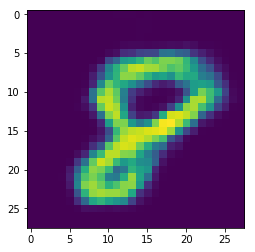

In [15]:
d = 8
test_seq = tf.cast(test_images[d][:1,...],np.float32)
samp = models[d](test_seq).mean()[0,...,0]

plt.imshow(samp)

# Counterfactual

In [0]:
N, d1, d2 = 12, 2, 5
test_img = tf.cast(test_images[d1][:N,...],np.float32)
transfer = decoders[d2](encoders[d1](test_img)).mean()

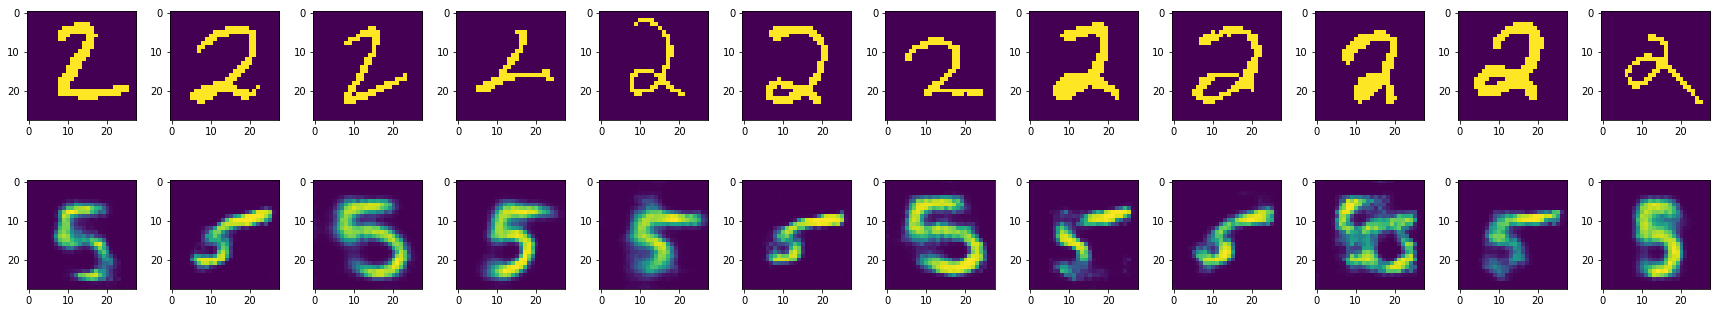

In [17]:
fig, ax = plt.subplots(2,N, figsize=(N*2,5))
for n in range(N):
  ax[0,n].imshow(test_img[n,...,0])
  ax[1,n].imshow(transfer[n,...,0])

plt.tight_layout()

# Classification

In [0]:
def classify(imgs, models, D=10):
  return tfm.argmax(tf.stack([models[d](imgs).log_prob(imgs) for d in range(D)]),0)

In [0]:
def confusion(test_images, models, batch_size=100, D=10):
  confusion_matrix = np.zeros((D,D))
  for d in range(D):
    sz = test_images[d].shape[0]
    for b_id in range(0,sz,batch_size):
      test_img = tf.cast(test_images[d][b_id:min(sz,b_id + batch_size),...], np.float32)
      classes = classify(test_img, models, D).numpy()
      for d_p in range(D):
        confusion_matrix[d,d_p] += np.sum(classes == d_p)
  return confusion_matrix

In [0]:
conf = confusion(test_images,models,BATCH_SIZE,D)

0.9433


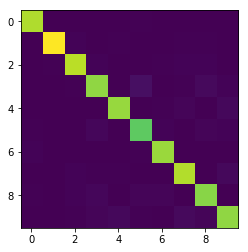

In [21]:
acc = np.sum(np.diag(conf))/np.sum(conf)
print(acc)

plt.imshow(conf)

# Discriminative Model

In [0]:
def create_discriminator(input_shape, latent_dim, base_filters, D=10):
    discriminator = tfk.Sequential([
      tfkl.InputLayer(input_shape=input_shape),
      tfkl.Lambda(lambda x: x - 0.5),
      tfkl.Conv2D(base_filters, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
      #tfkl.Conv2D(base_filters, 5, strides=2,
      #          padding='same', activation=tf.nn.leaky_relu),
      #tfkl.Conv2D(2 * base_filters, 5, strides=1,
      #          padding='same', activation=tf.nn.leaky_relu),
      tfkl.Conv2D(2 * base_filters, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
      tfkl.Conv2D(4 * latent_dim, 7, strides=2,
                padding='valid', activation=tf.nn.leaky_relu),
      tfkl.Flatten(),
      tfkl.Dense(D, activation="softmax"),
      #tfpl.DistributionLambda(lambda p: tfd.Categorical(probs=p))
      ])
    return discriminator

In [0]:
def minibatches_with_labels(data,labels,mb_size=1):
  return tf.data.Dataset.from_tensor_slices((data,labels)).batch(mb_size)

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = preprocess(train_images)
test_images = preprocess(test_images)
train_labels = train_labels.astype("int32")
test_labels = test_labels.astype("int32")

In [0]:
D = 10
img_shape = train_images.shape[1:]
encoded_size = 8
base_depth = 24

In [0]:
BATCH_SIZE = 100

train_dataset = minibatches_with_labels(train_images,train_labels,BATCH_SIZE)
test_dataset = minibatches_with_labels(test_images,test_labels,BATCH_SIZE)

In [27]:
discriminator = create_discriminator(img_shape, encoded_size, base_depth, D)

discriminator.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])

discriminator.fit(train_dataset, epochs=15, validation_data=test_dataset)

Epoch 1/15
600/600 [==============================] - 8s 13ms/step - loss: 0.2732 - accuracy: 0.9172 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
600/600 [==============================] - 6s 10ms/step - loss: 0.0906 - accuracy: 0.9723 - val_loss: 0.0787 - val_accuracy: 0.9720
Epoch 3/15
600/600 [==============================] - 6s 10ms/step - loss: 0.0643 - accuracy: 0.9805 - val_loss: 0.0723 - val_accuracy: 0.9754
Epoch 4/15
600/600 [==============================] - 6s 9ms/step - loss: 0.0495 - accuracy: 0.9852 - val_loss: 0.0678 - val_accuracy: 0.9775
Epoch 5/15
600/600 [==============================] - 6s 10ms/step - loss: 0.0394 - accuracy: 0.9881 - val_loss: 0.0683 - val_accuracy: 0.9790
Epoch 6/15
600/600 [==============================] - 6s 9ms/step - loss: 0.0321 - accuracy: 0.9902 - val_loss: 0.0695 - val_accuracy: 0.9785
Epoch 7/15
600/600 [==============================] - 6s 9ms/step - loss: 0.0268 - accuracy: 0.9916 - val_loss: 0.0738 - val_accuracy: 0